In [1]:

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import json
import pickle
import gzip
import networkx as nx
from tqdm import tqdm
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept
import time
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs, sample_relevance_cavs, sample_bbox_cavs, sample_all_relevances_cavs

from expbasics.dim_reduction import visualize_dr, get_dr_methods, clean_centroids, centroid_distances
from expbasics.biased_noisy_dataset import get_biased_loader, BiasedNoisyDataset
from expbasics.background_dataset import BackgroundDataset
from expbasics.test_dataset import TestDataset
from expbasics.test_dataset_background import TestDataset as TestDatasetBackground
from expbasics.causal_discovery import remove_empty, causal_discovery
from expbasics.ground_truth_measures import GroundTruthMeasures

from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid
from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.crp_attribution import CRPAttribution
from expbasics.network import load_model, train_network, accuracy_per_class
from measures0_to_2_new import AllMeasures


from expbasics.visualizations import sum_it, data_iterations, my_plot_grid

%reload_ext autoreload
%autoreload 2
plt.rcParams['text.usetex'] = True
matplotlib.rcParams.update({'font.family': 'serif', "font.size": 14})

In [2]:
model_path = "../clustermodels/final"
experiment_name = "attribution_output"
sample_set_size = 128
layer_name = "convolutional_layers.6"
is_random = False
model_type = "watermark"
iterations = 16
datasettype = BiasedNoisyDataset
mask = "bounding_box"
accuracypath = "outputs/retrain.json" 
relsetds = TestDataset(length=300, im_dir="watermark_test_data")


# Experiment 2:
""" model_path = "../clustermodels/background"
experiment_name = "overlap_attribution"
sample_set_size = 128
layer_name = "convolutional_layers.6"
is_random = False
model_type = "overlap"
iterations = 10
datasettype = BackgroundDataset
mask = "shape"
accuracypath = "outputs/unlocalized3.json"
relsetds = TestDatasetBackground(length=300, im_dir="overlap_test_data") """


ms = AllMeasures(
    "../dsprites-dataset/images/",
    sample_set_size,
    layer_name,
    model_path,
    experiment_name,
)

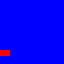

In [327]:
#bgds = TestDatasetBackground(length=300, im_dir="overlap_test_data") 

x = relsetds.load_watermark_mask(3)
imgify(x)

In [191]:
# TEST MEASURES FOR RELEVANCE MAXIMIZATION
import gzip
from time import sleep
from sklearn.metrics import matthews_corrcoef, normalized_mutual_info_score

sizes = []
biases = list(np.round(np.linspace(0, 1, 51), 3))
bias_arr = range(0, 51, 5)
num_it = 2
for b in bias_arr:
    model_name = f"{experiment_name}_{to_name(biases[b], num_it)}"
    model = load_model(model_path, biases[b], num_it, model_type)
    crpa = CRPAttribution(model, relsetds, model_path, model_name)
    # crpa.compute_feature_vis()
    # sleep(1)
    filename = f"outputs/{experiment_name}/{b}_{num_it}.gz"
    with gzip.open(filename, mode="rb") as f:
        r_m_info = pickle.load(f)
    rels0 = r_m_info[2][:, 0].to(dtype=torch.float)
    rels1 = r_m_info[2][:, 1].to(dtype=torch.float)
    with open(
        f"{crpa.fv_path}/RelMax_sum_normed/convolutional_layers.6_data.npy", "rb"
    ) as f:
        data = torch.from_numpy(np.load(f))
    with open(
        f"{crpa.fv_path}/RelMax_sum_normed/convolutional_layers.6_rel.npy", "rb"
    ) as f:
        relevances = torch.from_numpy(np.load(f))
    with open(
        f"{crpa.fv_path}/RelMax_sum_normed/convolutional_layers.6_rf.npy", "rb"
    ) as f:
        frames = torch.from_numpy(np.load(f))
    print(frames.shape, frames[0,: ])
    len_set = 20
    info = torch.zeros((8, len_set, 4))
    overlap = torch.zeros((8, 5))
    for neuron in range(8):
        indices = data[:len_set, neuron]
        for i, ind in enumerate(indices):
            img, label = relsetds[ind]
            (latents, has_watermark, offset) = relsetds.get_item_info(ind)
            info[neuron, i, 0] = label
            info[neuron, i, 1] = int(has_watermark)
        overlap[neuron, 0] = torch.count_nonzero(info[neuron, :, 1]) / (
            max(
                torch.count_nonzero(info[neuron, :, 0] == 1),
                torch.count_nonzero(info[neuron, :, 0] == 0),
            )
        )
        overlap[neuron, 1] = matthews_corrcoef(
            info[neuron, :, 0], info[neuron, :, 1]
        )
    sizes.append(
        [
            torch.mean(
                torch.sum(
                    torch.abs(
                        rels1 * overlap[None, :, 0] - rels0 * overlap[None, :, 0]
                    ),
                    dim=1,
                )
            ),
            torch.sum(
                torch.abs(
                    rels1.mean(dim=0) * overlap[:, 0]
                    - rels0.mean(dim=0) * overlap[:, 0]
                )
            ),
            torch.sum(rels1.mean(dim=0) * (overlap[:, 1])),
            torch.sum(rels1.mean(dim=0) * (overlap[:, 0])),
        ]
    )
#
labels = [
    "wm_vs_max_shape_causal",
    "overlap_mean",
    "overlap_pure",
    "overlap_pure0",
]
# rel_weight_by_img_causal_abs
# torch.mean(torch.sum(torch.abs(rels1 * perimg - rels0 * perimg0), dim=1)) / 2

with open("sizesRelMax.pickle", "wb") as f:
    pickle.dump(sizes, f)

torch.Size([40, 8]) tensor([ 0, 20, 19, 36,  0, 35, 44, 36])
torch.Size([40, 8]) tensor([ 0, 20,  0, 19,  0, 22, 31,  0])
torch.Size([40, 8]) tensor([ 2, 44, 10, 43, 43, 42,  3,  6])
torch.Size([40, 8]) tensor([15,  6,  8, 48, 41, 26, 48,  0])
torch.Size([40, 8]) tensor([11, 30, 28, 44,  0, 37, 23, 26])
torch.Size([40, 8]) tensor([48, 19, 20, 11, 29, 26, 27, 28])
torch.Size([40, 8]) tensor([45, 44, 19, 43, 25, 19, 42, 45])
torch.Size([40, 8]) tensor([24, 43,  0,  0, 36,  6, 42, 42])
torch.Size([40, 8]) tensor([48, 14,  7,  8, 47,  3,  1, 38])
torch.Size([40, 8]) tensor([28, 42,  0,  2, 42, 20, 23, 29])
torch.Size([40, 8]) tensor([ 0, 35, 48,  6,  7, 41, 48, 42])


tensor([ 0.0000,  0.1661,  0.2219,  0.1769, -0.0590,  0.0159, -0.0274, -0.0479])


/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


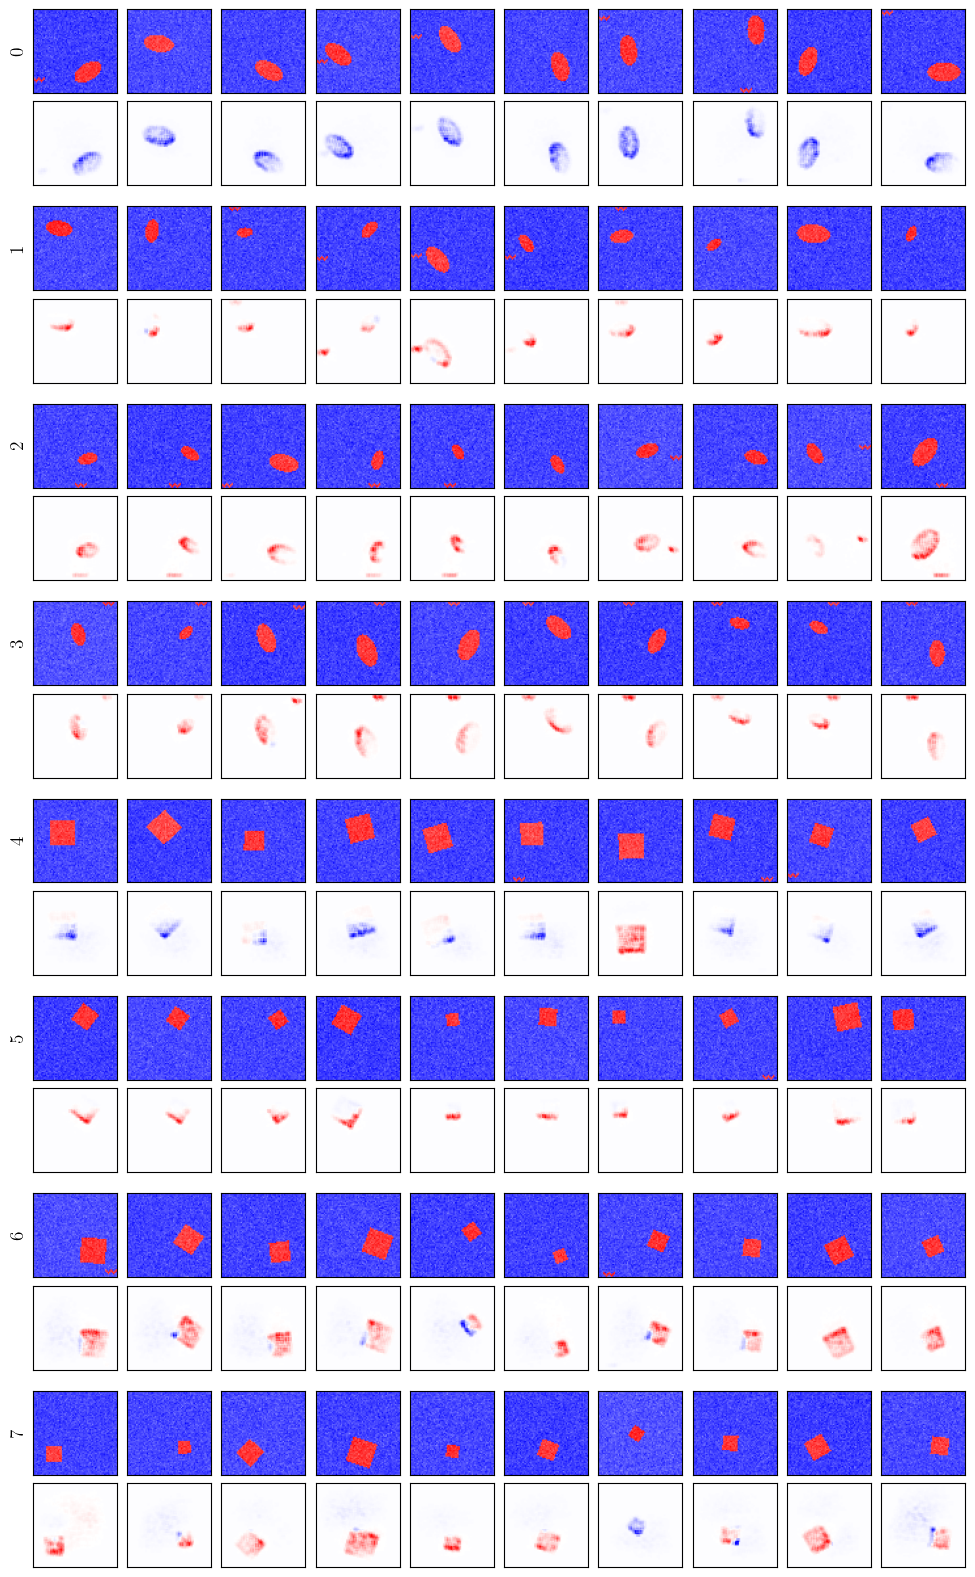

In [330]:
b, num_it = 50, 2
from expbasics.crp_attribution import get_bbox

model_name = f"{experiment_name}_{to_name(biases[b], num_it)}"
model = load_model(model_path, biases[b], num_it, model_type)
crpa = CRPAttribution(model, relsetds, model_path, model_name)
filename = f"outputs/{experiment_name}/{b}_{num_it}.gz"
with gzip.open(filename, mode="rb") as f:
    r_m_info = pickle.load(f)
rels0 = r_m_info[2][:, 0].to(dtype=torch.float)
rels1 = r_m_info[2][:, 1].to(dtype=torch.float)
print((rels1).mean(dim=0))
crpa.make_all_references(
    layer_name,
    list(range(8)),
    "relevance",
)

In [328]:
# TEST MEASURES FOR RELEVANCE MAXIMIZATION
import gzip
from time import sleep
from sklearn.metrics import matthews_corrcoef, normalized_mutual_info_score

sizes = []
biases = list(np.round(np.linspace(0, 1, 51), 3))
bias_arr = range(0, 51, 5)
num_it = 2
for b in bias_arr:
    model_name = f"{experiment_name}_{to_name(biases[b], num_it)}"
    model = load_model(model_path, biases[b], num_it, model_type)
    crpa = CRPAttribution(model, relsetds, model_path, model_name)
    # crpa.compute_feature_vis()
    # sleep(1)
    with open(
        f"{crpa.fv_path}/RelMax_sum_normed/convolutional_layers.6_data.npy", "rb"
    ) as f:
        data = torch.from_numpy(np.load(f))
    len_set = 8

    filename = f"outputs/{experiment_name}/{b}_{num_it}.gz"
    with gzip.open(filename, mode="rb") as f:
        r_m_info = pickle.load(f)
    rels1 = r_m_info[2][:, 1].to(dtype=torch.float)
    ref_c = crpa.fv.get_max_reference(
        list(range(8)),
        layer_name,
        "relevance",
        (0, len_set),
        composite=crpa.composite,
        rf=True,
        plot_fn=get_bbox,  # vis_simple,#
    )
    info = torch.zeros((8, len_set, 4))
    overlap = torch.zeros((8, 5))
    for neuron in range(8):
        indices = data[:len_set, neuron]
        for i, ind in enumerate(indices):
            img, label = relsetds[ind]
            (latents, has_watermark, offset) = relsetds.get_item_info(ind)
            """ print(
                [
                    max(0, 57 + offset[0]),
                    max(0, 58 + offset[0]) + 5,
                    max(offset[1] + 3, 0),
                    max(offset[1] + 4, 0) + 10,
                ],
                ref_c[neuron][i],
            ) """
            info[neuron, i, 0] = label
            info[neuron, i, 1] = int(has_watermark)
            if has_watermark:
                m1 = torch.zeros(64, 64)
                m2 = torch.zeros(64, 64)
                m1[
                    max(0, 57 + offset[0]) : max(0, 58 + offset[0]) + 5,
                    max(offset[1] + 3, 0) : max(offset[1] + 4, 0) + 10,
                ] = 1
                m2[
                    ref_c[neuron][i][0] : ref_c[neuron][i][1],
                    ref_c[neuron][i][2] : ref_c[neuron][i][3],
                ] = 1
                #print(neuron,i, ref_c[neuron][i])
                if i == 0:
                    img, l = relsetds[ind]
                    imgify(m1 + img.view(64, 64))
                jaccard = (m1 * m2).sum() / (m1.sum() + m2.sum() - (m1 * m2).sum())
                print(neuron, (m1 * m2).sum(), m2.sum(), jaccard)
                # row1, row2, col1, col2
                info[neuron, i, 2] = jaccard
        overlap[neuron, 0] = torch.sum(info[neuron, :, 2])
    sizes.append(
        [
            torch.sum(torch.abs((overlap[:, 0]) * rels1.mean(dim=0))),
        ]
    )
labels = [
    "IoU_perimg_weighted",
]
with open("sizesRelMaxIoU.pickle", "wb") as f:
    pickle.dump(sizes, f)

0 tensor(0.) tensor(506.) tensor(0.)
0 tensor(0.) tensor(420.) tensor(0.)
0 tensor(0.) tensor(484.) tensor(0.)
0 tensor(0.) tensor(420.) tensor(0.)
0 tensor(0.) tensor(783.) tensor(0.)
1 tensor(0.) tensor(380.) tensor(0.)
1 tensor(0.) tensor(525.) tensor(0.)
1 tensor(0.) tensor(462.) tensor(0.)
1 tensor(0.) tensor(504.) tensor(0.)
2 tensor(0.) tensor(399.) tensor(0.)
2 tensor(0.) tensor(588.) tensor(0.)
2 tensor(0.) tensor(704.) tensor(0.)
2 tensor(0.) tensor(460.) tensor(0.)
3 tensor(0.) tensor(437.) tensor(0.)
3 tensor(0.) tensor(380.) tensor(0.)
3 tensor(0.) tensor(546.) tensor(0.)
3 tensor(0.) tensor(667.) tensor(0.)
4 tensor(60.) tensor(3969.) tensor(0.0151)
4 tensor(60.) tensor(3969.) tensor(0.0151)
4 tensor(60.) tensor(3969.) tensor(0.0151)
4 tensor(60.) tensor(3969.) tensor(0.0151)
4 tensor(44.) tensor(3969.) tensor(0.0111)
5 tensor(0.) tensor(440.) tensor(0.)
5 tensor(0.) tensor(644.) tensor(0.)
5 tensor(0.) tensor(462.) tensor(0.)
6 tensor(6.) tensor(870.) tensor(0.0065)
6 te

In [34]:
# TEST MEASURES FOR PREDICTIONS
import gzip

softmax = torch.nn.Softmax(dim=1)
sizes = []
bias_arr = range(0, 51)
softmaxhm = torch.nn.Softmax(dim=1)
for b in bias_arr:
    filename = f"outputs/measures/{b}_{6}.gz"
    with gzip.open(filename, mode="rb") as f:
        r_m_info = pickle.load(f)
    pred0s = r_m_info[1][:, 0].to(dtype=torch.float)
    pred1s = r_m_info[1][:, 1].to(dtype=torch.float)
    maxval = max(pred0s.max(), pred1s.abs().max())

    pred0sabs = softmax(pred0s)
    pred1sabs = softmax(pred1s)
    sizes.append(
        [
            torch.mean(torch.sum(torch.abs(pred1sabs - pred0sabs), dim=1) / 2),
            torch.mean(
                (
                    1
                    - torch.nn.functional.cosine_similarity(
                        pred1sabs,
                        pred0sabs,
                        dim=1,
                    )
                )
            ),
            torch.mean(ms.kernel1d(pred1sabs, pred0sabs, dim=1)) / 2,
            torch.mean(torch.sqrt(ms.kernel1d(pred1sabs, pred0sabs, dim=1))) / 2,
        ]
    )
labels = ["mlc_abs", "mlc_cosine", "mlc_kernel_normed", "mlc_euclid_normed", "mlc_kernel", "mlc_euclid"]

In [38]:
# TEST MEASURES FOR RELEVANCES
sizes = []
bias_arr = range(0, 51)
indices = np.round(np.linspace(0, 491519, 128)).astype(int)
softmaxhm = torch.nn.Sigmoid()
for b in bias_arr:
    filename = f"outputs/measures/{b}_{10}.gz"
    with gzip.open(filename, mode="rb") as f:
        r_m_info = pickle.load(f)
    rels0 = r_m_info[2][:, 0].to(dtype=torch.float)
    rels1 = r_m_info[2][:, 1].to(dtype=torch.float)
    """    divby = torch.count_nonzero(torch.var(torch.cat((rels1, rels0)), dim=0) > 0.001)
    maxval =  max(
                    rels0.abs().max(),
                    rels1.abs().max(),
                )
    only_indices = torch.var(torch.cat((rels1, rels0)), dim=0) > 0.001
    print( maxval,divby, maxval * divby, torch.var(torch.cat((rels1, rels0)), dim=0) > 0.001) """
    sizes.append(
        [
            torch.mean(ms.kernel1d(rels1, rels0, dim=1)),
            torch.mean(torch.sqrt(ms.kernel1d(rels1, rels0, dim=1))),
            torch.mean(torch.sqrt(torch.sum(((rels1 - rels0) ** 2), dim=1))),
            torch.mean(torch.sum(((rels1 - rels0) ** 2), dim=1)),
        ]
    )
labels = [
    "m2_rel_kernel",
    "m2_rel_euclid",
    "m2_rel_euclid_old",
    "m2_rel_kernel_old",
]
# imgify(hm1s[60],resize=800, grid=(1,8))
# my_plot_grid(torch.cat((hm1s[70:71], hm0s[70:71])),2, 8, resize=3, norm=True)
# rels1.abs().mean(dim=(0)).tolist(), rels0.abs().mean(dim=(0)).tolist()

In [62]:
# TEST MEASURES WITH MAC HEATMAP
import gzip

sizes = []
bias_arr = range(0, 51,10)
indices = np.round(np.linspace(0, 491519, 128)).astype(int)
softmaxhm = torch.nn.Softmax(dim=1)
for b in bias_arr:
    filename = f"outputs/measures/{b}_{15}.gz"
    with gzip.open(filename, mode="rb") as f:
        r_m_info = pickle.load(f)
    hm0s = r_m_info[0][:, 0].to(dtype=torch.float64)
    hm1s = r_m_info[0][:, 1].to(dtype=torch.float64)
    # rels0 = r_m_info[2][:, 0].to(dtype=torch.float)
    rels1 = r_m_info[2][:, 1].to(dtype=torch.float)
    weights = rels1.abs()
    maxval = max(
        hm0s.abs().sum(dim=(1, 2, 3)).max(),
        hm1s.abs().sum(dim=(1, 2, 3)).max(),
        # torch.max(hm0s.abs(),dim=0).values.max() * 128,
        # torch.max(hm1s.abs(),dim=0).values.max()* 128,
    )

    # only_non_zeros = np.where(np.logical_or(hm0s != 0 , hm1s != 0 ))
    # print(len(only_non_zeros[0]))
    hm0sabs = hm0s / (
        maxval
    )  # (hm0s.abs().sum(dim=(1, 2, 3))[:,None,None,None] + 1e-10)#(maxval)
    hm1sabs = hm1s / (
        maxval
    )  # (hm1s.abs().sum(dim=(1, 2, 3))[:,None,None,None]+ 1e-10)#(maxval)
    """ hm0sabs = hm0s[only_non_zeros]
    hm1sabs = hm1s[only_non_zeros]
    len_non_zero = len(only_non_zeros[0]) """
    sizes.append(
        np.array(
            [
                ms.cosine_distance(hm1s, hm0s),
                torch.mean(
                    torch.tensor(
                        [
                            ms.kernel_distance(hm1s[n], hm0s[n], kernel="cosine")
                            for n in range(128)
                        ]
                    )
                ),
            ]
        )
    )
labels = [
    "m2_mac_cosine",
    "m2_mac_kernel_cosine",
]

with open("sizes.pickle", "wb") as f:
    pickle.dump(sizes, f)

In [170]:
# TEST MEASURES WITH HEATMAP MASKED
sizes = []
bias_arr = range(0, 51)
indices = np.round(np.linspace(0, 491519, 128)).astype(int)
softmaxhm = torch.nn.Softmax(dim=1)
for b in bias_arr:
    filename = f"outputs/measures/{b}_{13}.gz"
    with gzip.open(filename, mode="rb") as f:
        r_m_info = pickle.load(f)
    hm0s = r_m_info[0][:, 0].to(dtype=torch.float)
    hm1s = r_m_info[0][:, 1].to(dtype=torch.float)
    rels0 = r_m_info[2][:, 0].to(dtype=torch.float)
    rels1 = r_m_info[2][:, 1].to(dtype=torch.float)
    (
        m2_rma_sum,
        m2_rma_weighted,
        m2_pg_sum,
        m2_pg_weighted,
        m2_rra_sum,
        m2_rra_weighted,
        m2_bbox_rel,
        rma_total,
    ) = (0, 0, 0, 0, 0, 0, 0, 0)
    for n, ind in enumerate(indices):
        wm_mask = ms.ds.load_watermark_mask(ind)
        """ _, _, offset = ms.ds.get_item_info(ind)
        mask = torch.zeros(64, 64).to(ms.tdev)
        mask[
            max(0, 57 + offset[0]) : max(0, 58 + offset[0]) + 5,
            max(offset[1] + 3, 0) : max(offset[1] + 4, 0) + 10,
        ] = 1 """

        weight = rels1[n]
        hms_values1 = ms.heatmap_values(hm1s[n], wm_mask)
        hms_values0 = ms.heatmap_values(hm0s[n], wm_mask)
        divby = max(1, int(hms_values1["non_empty"]), int(hms_values0["non_empty"]))
        # pure rma summed
        m2_rma_sum += torch.sum(
            torch.abs(hms_values1["rma"] - hms_values0["rma"])
        )  / divby
        # rma weighted sum
        m2_rma_weighted += torch.sum(
            torch.abs((hms_values1["rma"] - hms_values0["rma"]) * weight)
        )
        # pg sum
        m2_pg_sum += torch.sum(torch.abs(hms_values1["pg"] - hms_values0["pg"])) / divby
        # pg weighted sum
        m2_pg_weighted += torch.sum(
            torch.abs((hms_values1["pg"] - hms_values0["pg"]) * weight)
        )
        # rra sum
        m2_rra_sum += (
            torch.sum(torch.abs(hms_values1["rra"] - hms_values0["rra"])) #/ divby
        )
        # rra weighted sum
        m2_rra_weighted += torch.sum(
            torch.abs((hms_values1["rra"] - hms_values0["rra"]) * weight)
        )
        # relevance within summed
        m2_bbox_rel += torch.sum(
            torch.abs(hms_values1["rel_within"] - hms_values0["rel_within"])
        ) / max(1, int(hms_values1["non_empty"]), int(hms_values0["non_empty"]))

    sizes.append(
        np.array(
            [
                m2_rma_sum / 128,
                m2_rma_weighted / 128,
                m2_pg_sum / 128,
                m2_pg_weighted / 128,
                m2_rra_sum / 128,
                m2_rra_weighted / 128,
                m2_bbox_rel / 128,
            ]
        )
    )

labels = [
    "m2_rma_sum",
    "m2_rma_weighted",
    "m2_pg_sum",
    "m2_pg_weighted",
    "m2_rra_sum",
    "m2_rra_weighted",
    "m2_bbox_rel",
]


with open("sizes.pickle", "wb") as f:
    pickle.dump(sizes, f)
# imgify(hm1s[60],resize=800, grid=(1,8))
# my_plot_grid(torch.cat((hm1s[70:71], hm0s[70:71])),2, 8, resize=3, norm=True)
# rels1.abs().mean(dim=(0)).tolist(), rels0.abs().mean(dim=(0)).tolist()

In [19]:
# TEST MEASURES WITH HEATMAP MASKED PROPERLY WEIGHTED
sizes = []
bias_arr = torch.tensor(list(range(0, 51, 5)))
indices = np.round(np.linspace(0, 491519, 128)).astype(int)
for b in bias_arr:
    filename = f"outputs/attribution_output/{b}_{4}.gz"
    with gzip.open(filename, mode="rb") as f:
        r_m_info = pickle.load(f)
    hm0s = r_m_info[0][:, 0].to(dtype=torch.float)
    hm1s = r_m_info[0][:, 1].to(dtype=torch.float)
    rels0 = r_m_info[2][:, 0].to(dtype=torch.float)
    rels1 = r_m_info[2][:, 1].to(dtype=torch.float)
    (
        rel_within_div_8,
        rel_within_weighted,
        rel_within_div_total_max_square,
        rel_within_div_total_max,
        rel_within,
        rel_within_square,
    ) = (0, 0, 0, 0, 0, 0)
    for n, ind in enumerate(indices):
        # wm_mask = ms.ds.load_watermark_mask(ind)

        _, _, offset = ms.ds.get_item_info(ind)
        mask = torch.zeros(64, 64).to(ms.tdev)
        mask[
            max(0, 57 + offset[0]) : max(0, 58 + offset[0]) + 5,
            max(offset[1] + 3, 0) : max(offset[1] + 4, 0) + 10,
        ] = 1

        weight = rels1[n]
        hms_values1 = ms.heatmap_values(hm1s[n], mask)
        hms_values0 = ms.heatmap_values(hm0s[n], mask)

        rel_within_div_8 += torch.sum(
            torch.square((hms_values1["rel_within"] - hms_values0["rel_within"]) / 8)
        )

        rel_within_div_total_max_square += torch.square(
            torch.sum(torch.abs(hms_values1["rel_within"] - hms_values0["rel_within"]))
            / max(
                hms_values1["rel_total"].abs().sum(),
                hms_values0["rel_total"].abs().sum(),
                1e-10,
            )
        )

        rel_within_div_total_max += torch.sum(
            torch.abs(hms_values1["rel_within"] - hms_values0["rel_within"])
        ) / max(
            hms_values1["rel_total"].abs().sum(),
            hms_values0["rel_total"].abs().sum(),
            1e-10,
        )
        rel_within += (
            torch.sum(
                torch.abs(
                    (
                        hms_values1["rel_within"]
                        / (hms_values1["rel_total"].abs() + 1e-10)
                    )
                    - (
                        hms_values0["rel_within"]
                        / (hms_values0["rel_total"].abs() + 1e-10)
                    )
                )
            )
            / 2
        )

        rel_within_square += torch.sum(
            torch.square(
                (
                    (
                        hms_values1["rel_within"]
                        / (hms_values1["rel_total"].abs() + 1e-10)
                    )
                    - (
                        hms_values0["rel_within"]
                        / (hms_values0["rel_total"].abs() + 1e-10)
                    )
                )
            )
        )

    sizes.append(
        np.array(
            [
                rel_within_div_8 / 128,
                rel_within_div_total_max_square / 128,
                rel_within_div_total_max / 128,
                rel_within / 128,
                rel_within_square / 128,
            ]
        )
    )

labels = [
    "rel_within_div_8",
    "rel_within_div_total_max_square",
    "rel_within_div_total_max",
    "rel_within",
    "rel_within_square",
]


with open("sizesRMA.pickle", "wb") as f:
    pickle.dump(sizes, f)
# imgify(hm1s[60],resize=800, grid=(1,8))
# my_plot_grid(torch.cat((hm1s[70:71], hm0s[70:71])),2, 8, resize=3, norm=True)
# rels1.abs().mean(dim=(0)).tolist(), rels0.abs().mean(dim=(0)).tolist()

In [35]:
# TEST MEASURES WITH HEATMAP MASKED PROPERLY WEIGHTED
sizes = []
bias_arr = range(0, 51, 5)
num_it = 4
indices = np.round(np.linspace(0, 491519, 128)).astype(int)
for b in bias_arr:
    filename = f"outputs/attribution_output/{b}_{num_it}.gz"
    with gzip.open(filename, mode="rb") as f:
        r_m_info = pickle.load(f)
    hm0s = r_m_info[0][:, 0].to(dtype=torch.float)
    hm1s = r_m_info[0][:, 1].to(dtype=torch.float)
    rels0 = r_m_info[2][:, 0].to(dtype=torch.float)
    rels1 = r_m_info[2][:, 1].to(dtype=torch.float)
    (
        rel_within_div_8,
        rel_within_weighted,
        rel_within_div_total_max_square,
        rel_within_div_total_max,
        rel_within,
        rel_within_square,
        rel_pure_div_total,
        rel_outside,
    ) = (0, 0, 0, 0, 0, 0, 0, 0)
    rel_within_pure = 0
    rel_total_pure = 0
    maxval = max(
        hm0s.abs().sum(dim=(1, 2, 3)).max(),
        hm1s.abs().sum(dim=(1, 2, 3)).max(),
    )
    if maxval > 0:
        hm0sabs = hm0s / maxval
        hm1sabs = hm1s / maxval
    else:
        hm0sabs = hm0s
        hm1sabs = hm1s
    for n, ind in enumerate(indices):
        # wm_mask = ms.ds.load_watermark_mask(ind)
        max_perimg = max(
            hm0s[n].abs().sum(dim=(0, 1, 2)).max(),
            hm1s[n].abs().sum(dim=(0, 1, 2)).max(),
        )

        mask = ms.ds.load_watermark_mask(ind)
        mask = mask.view(64, 64)
        shapemask = ms.ds.load_shape_mask(ind)
        shapemask = shapemask.view(64, 64).detach().numpy()

        weight = rels1[n]
        hms_values1sha = ms.heatmap_values(hm1s[n], shapemask)
        hms_values0sha = ms.heatmap_values(hm0s[n], shapemask)

        hms_values1 = ms.heatmap_values(hm1s[n], mask)
        hms_values0 = ms.heatmap_values(hm0s[n], mask)
        # print(weight.abs().sum(), weight)
        rel_tot_1 = torch.where(
            hms_values1["rel_total"] > 0, hms_values1["rel_total"], 1
        )
        rel_tot_0 = torch.where(
            hms_values0["rel_total"] > 0, hms_values0["rel_total"], 1
        )
        # print(max_perimg)
        if max_perimg > 0:
            rel_within_div_8 += (
                torch.sum(
                    torch.abs((hms_values1["rel_within"] - hms_values0["rel_within"]))
                )
                / max_perimg
            )

            rel_within_div_total_max_square += torch.sum(
                torch.abs(
                    (hms_values1["rel_within"] - hms_values0["rel_within"]) * weight
                )
                / max_perimg
            )
        for neur in range(8):
            if (
                hms_values1["rel_within"][neur] != 0
            ):
                rel_within_div_total_max += torch.abs(
                    (
                        (
                            hms_values1["rel_within"][neur]
                            / rel_tot_1[neur]
                        )
                        - (
                            hms_values0["rel_within"][neur]
                            / rel_tot_0[neur]
                        )
                    )
                )

    sizes.append(
        np.array(
            [
                rel_within_div_8 / 128,
                rel_within_div_total_max_square / 128,
                rel_within_div_total_max / 128,
            ]
        )
    )

labels = [
    "pure relevance difference",
    "weighted per image",
    "weighted per val of w",
]


with open("sizesRMAx.pickle", "wb") as f:
    pickle.dump(sizes, f)
# imgify(hm1s[60],resize=800, grid=(1,8))
# my_plot_grid(torch.cat((hm1s[70:71], hm0s[70:71])),2, 8, resize=3, norm=True)
# rels1.abs().mean(dim=(0)).tolist(), rels0.abs().mean(dim=(0)).tolist()

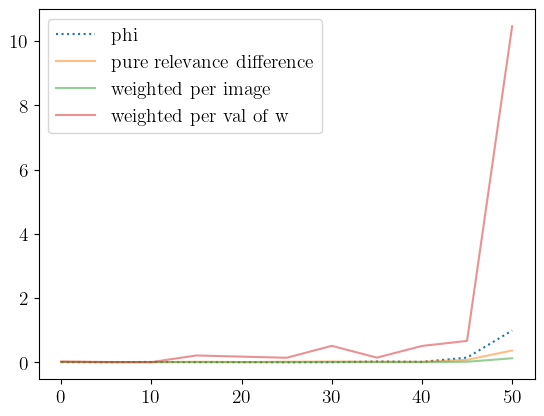

In [36]:
# TEST PLOT NORMALIZED VALUES TEST
with open("sizesRMAx.pickle", "rb") as f:
    sizes = pickle.load(f)
with gzip.open(f"all_measures_{sample_set_size}_{experiment_name}.pickle", "rb") as f:
    per_sample = pickle.load(f)
plt.plot(bias_arr, torch.mean(per_sample[bias_arr, num_it,:, 1], dim=1), label="phi", linestyle="dotted")
for meas in  range(len(labels)): # [3,4,5,6]: #
    vals = np.array([a[meas] for a in sizes])
    #vals = vals / vals.max()
    plt.plot(bias_arr, vals, label=labels[meas], alpha=0.5) #, alpha=0.5, linestyle="dashed"
plt.legend()

In [108]:
torch.mean(per_sample[:, :,:, 0], dim=(1,2))

tensor([-4.8284e-04, -1.9604e-03, -6.2295e-04, -1.9437e-03,  1.4652e-03,
        -4.8865e-04, -1.5340e-03,  4.8492e-04, -1.9552e-03, -1.4703e-03,
        -1.4675e-03, -2.4419e-03, -4.8770e-04, -2.2409e-03, -1.4662e-03,
        -2.4419e-03, -1.4678e-03, -2.9543e-03, -1.1415e-03, -2.1582e-03,
        -2.6844e-03, -4.8395e-04,  9.7923e-04, -1.5597e-06,  4.8516e-04,
        -4.8842e-04, -4.8746e-04,  0.0000e+00,  4.9070e-04,  9.7671e-04,
         9.7704e-04,  2.4867e-03,  5.5718e-03,  8.3054e-03,  2.4427e-03,
         3.4181e-03,  1.3861e-02,  1.2244e-02,  6.8463e-03,  6.8491e-03,
         1.2715e-02,  2.7732e-02,  2.0879e-02,  2.2205e-02,  3.4308e-02,
         6.0855e-02,  9.7670e-02,  1.4892e-01,  2.0320e-01,  2.3911e-01,
         4.2678e-01])

In [109]:
# TEST PLOT NORMALIZED VALUES TEST
with open("sizesRMA50.pickle", "rb") as f:
    sizesRMA50 = pickle.load(f)
for meas in range(len(labels)): # [1,2,3,4]: #
    vals = np.mean(np.array([a[meas] for a in sizes]))
    #vals = vals / vals.max()
    print(labels[meas], vals)

rel_within_div_8 0.104697324
rel_within_div_total_max_square 0.21291527
rel_within_div_total_max 0.45426643
rel_within 0.96986103
rel_within_square 1.0499572
rel_weighted 2.5975296


In [210]:
tst1 = torch.zeros((128, 8, 64 * 64))
tst2 = torch.zeros((128, 8, 64 * 64))
tst2[:, :, 0:18] = (torch.rand(128) * 100)[:,None,None]
tst2[:, :, 40:80] = 10
tst1[:, :, 40:80] = 10
softmax = torch.nn.Softmax(dim=2)
tst1 = softmax(tst1)
tst2 = softmax(tst2)
maxval = max(
    tst1.sum(dim=(1, 2)).max(),
    tst2.sum(dim=(1, 2)).max(),
)

def kernel2d(a, b):
    return (
        torch.nn.functional.conv2d(a, a)
        - 2 * torch.nn.functional.conv2d(a, b)
        + torch.nn.functional.conv2d(b, b)
    )


def kernel_distance(v0, v1):
    batched = kernel2d(
        v1.view(8, 1, 64, 64),
        v0.view(8, 1, 64, 64),
    )
    print(torch.sum(torch.tensor([batched[i, i] for i in range(8)])))
    return torch.sum(torch.diagonal(batched, 0)) 



kernel_distance(tst1[0], tst2[0])

tensor(0.6425)


tensor(0.6425)

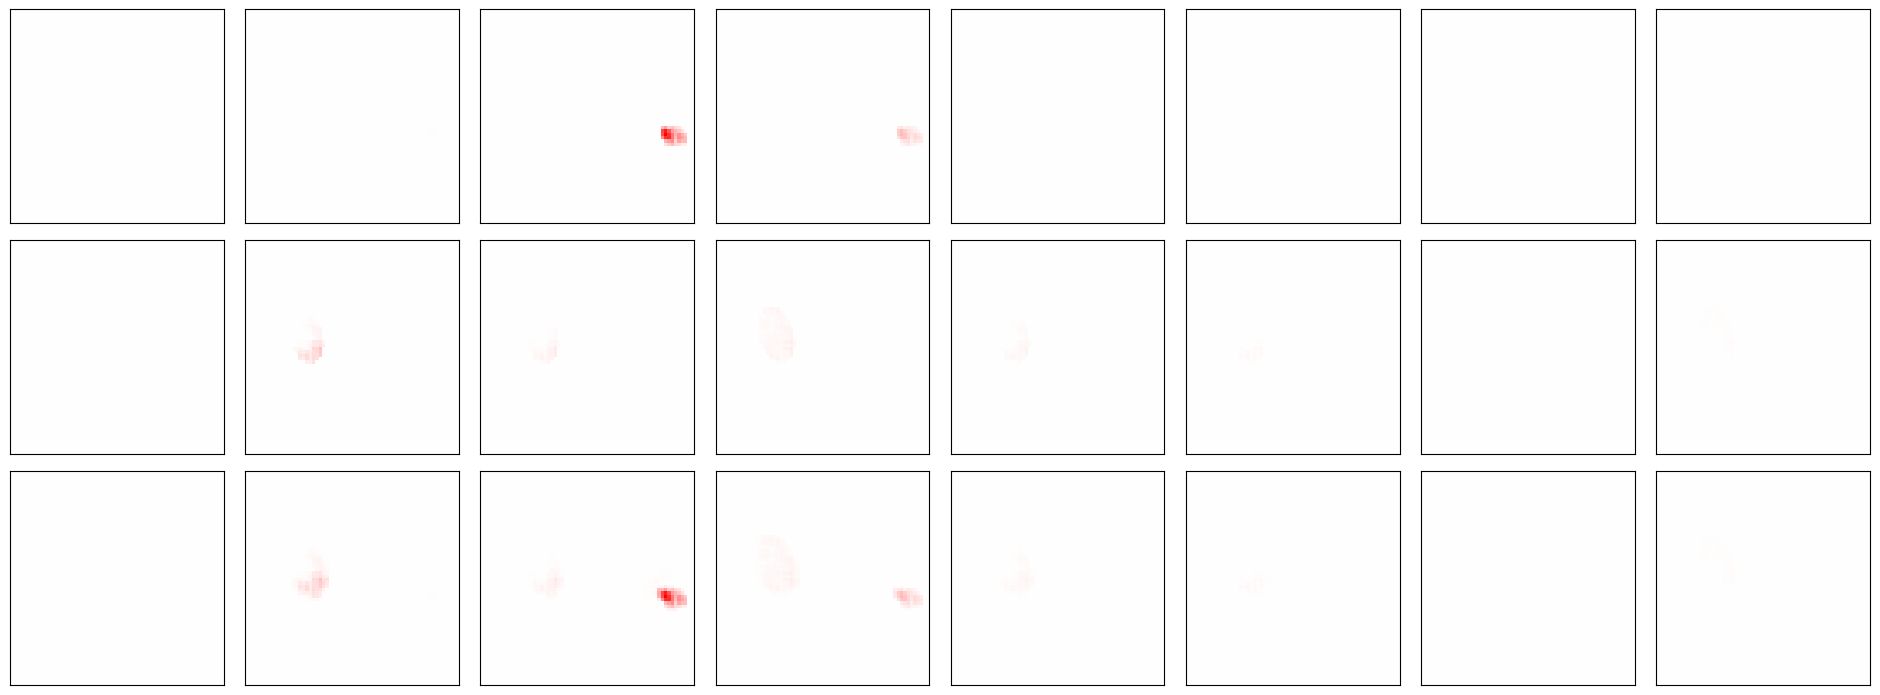

In [858]:
from measures0_to_2 import AllMeasures

bias = 1.0
num_it = 2
name = to_name(bias, num_it)
NAME = "../clustermodels/final"
ms = AllMeasures("../dsprites-dataset/images/", 5)
layer_name = "convolutional_layers.6"
index = 359500
model = load_model(NAME, bias, num_it)
crpa = CRPAttribution(model, ms.ds, "test", name)

image = ms.ds.load_image_wm(index, True)
image0 = ms.ds.load_image_wm(index, False)

lat, _, offset = ms.ds.get_item_info(index)

wm_mask = torch.zeros(64, 64)
wm_mask[
    max(0, 57 + offset[0]) : max(0, 58 + offset[0]) + 5,
    max(offset[1] + 3, 0) : max(offset[1] + 4, 0) + 10,
] = 1
shape_mask = ms.ds.load_shape_mask(index)
nlen = 8
conditions = [{layer_name: [i]} for i in crpa.layer_id_map[layer_name]]
res = 0.0

images = torch.zeros(3, nlen, 64, 64)
for attr in crpa.attribution.generate(
    image,
    conditions,
    crpa.composite,
    start_layer="linear_layers.2",
    record_layer=crpa.layer_names,
    verbose=False,
    batch_size=nlen,
):
    heatmaps_abs = attr.heatmap.abs()
    total_rel = torch.sum(heatmaps_abs, dim=(1, 2))
    images[0, :, :, :] = heatmaps_abs * wm_mask #+ 0.01 * wm_mask
    images[1, :, :, :] = heatmaps_abs * shape_mask[0]
    images[2, :, :, :] = heatmaps_abs
    wm_rel = torch.sum(heatmaps_abs * wm_mask, dim=(1, 2))
    shape_rel = torch.sum(heatmaps_abs * shape_mask[0], dim=(1, 2))
    vals = torch.zeros(nlen)
    for i in range(nlen):
        if wm_rel[i] > (shape_rel[i] * (wm_mask.sum() / (shape_mask.sum()))):
            vals[i] = wm_rel[i]
        else:
            vals[i] = 0
images = images.detach()
my_plot_grid(images, 3, nlen, resize=3, norm=True)

In [93]:
image1 = ms.ds.load_image_wm(index, True)
image0 = ms.ds.load_image_wm(index, False)

diff_heatmaps = torch.zeros(2, nlen, 64, 64)
hm1 = ms.heatmaps(image1, crpa)
hm0 = ms.heatmaps(image0, crpa)

predv_0 = model(image0)
predv_1 = model(image1)

diff_heatmaps[0, :, :, :] = hm1
diff_heatmaps[1, :, :, :] = hm0
#my_plot_grid(diff_heatmaps, 2, nlen, resize=3, norm=True)
def kernel(a,b):
    return torch.nn.functional.conv2d(a, a) - 2*torch.nn.functional.conv2d(a, b) + torch.nn.functional.conv2d(b, b) 
def kernel1d(a,b):
    return torch.nn.functional.conv1d(a, a) - 2*torch.nn.functional.conv1d(a, b) + torch.nn.functional.conv1d(b, b) 

truediff = kernel(wm_mask.view(1,1,64,64), shape_mask.view(1,1,64,64)) 
diffs = []
predv_0, predv_1 = predv_0 / 6.1175, predv_1 / 6.1175
print(predv_0 , predv_1 ,kernel1d(predv_0.view(1,1,2),predv_1.view(1,1,2)), ms.euclidean_distance(predv_1, predv_0))
batched = kernel(hm1.view(nlen,1,64,64), hm0.view(nlen,1,64,64))
#print(float(truediff), [float(batched[i,i].flatten()) for i in range(8)], sum([float(batched[i,i].flatten()) for i in range(8)]))
#my_plot_grid(diff_heatmaps, 2, nlen, resize=3, norm=True)


tensor([[ 0.6487, -0.1161]], grad_fn=<DivBackward0>) tensor([[-0.4496,  0.8052]], grad_fn=<DivBackward0>) tensor([[[2.0548]]], grad_fn=<AddBackward0>) 1.4334536790847778


tensor(0.1410)


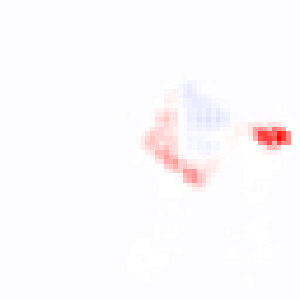

In [94]:
from zennit.composites import EpsilonPlusFlat
from zennit.attribution import Gradient


data = torch.randn(1, 3, 224, 224)
input_img = image1
composite = EpsilonPlusFlat()

with composite.context(model) as modified_model:
    output = modified_model(input_img)
    # gradient/ relevance wrt. class/output 0tensor(0.1172)
￼
tensor(3.7253e-09)
￼
' print(list(enumerate(ALL_MEASURES)))\nbiases = list(np.round(np.linspace(0, 1, 51), 3)) '
<matplotlib.legend.Legend at 0x7f80a3e564d0>
￼
￼
torch.Size([51, 16, 128, 22]) torch.Size([51, 22])
torch.Size([51, 22])
<matplotlib.legend.Legend at 0x7f8099b1bdc0>
￼
￼
    output.backward(gradient=torch.eye(2)[[1]])
vmax = input_img.grad.max()
print(vmax)
imgify(input_img.grad[0, 0], vmax=vmax, vmin=-vmax, resize=300)

tensor(0.1172)


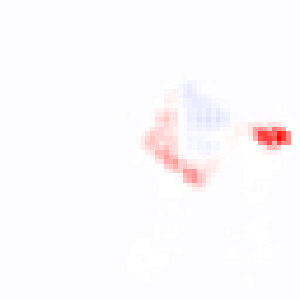

In [95]:
summed_hms = torch.sum(hm1 , dim=0)
vmaxhm = summed_hms.max()
print(vmaxhm)
imgify(summed_hms, vmax=vmaxhm, vmin=-vmaxhm, resize=300)

tensor(3.7253e-09)


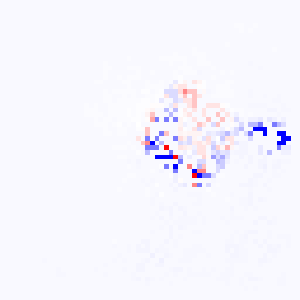

In [97]:
res = summed_hms * (vmax / vmaxhm) - input_img.grad[0, 0]
resmax = res.max()
print(resmax)
imgify(res, vmax=resmax, vmin=-resmax, resize=300)

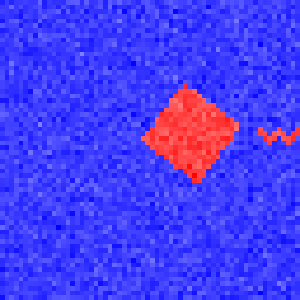

In [107]:
imgify(image1[0,0],resize=300)